# Overview: The Dataset and Challenge

Gilead Sciences is the sponsor for this year’s WiDS Datathon. They provided a rich, real-world dataset which contains information about demographics, diagnosis and treatment options, and insurance provided about patients who were diagnosed with breast cancer. The dataset originated from Health Verity, one of the largest healthcare data ecosystems in the US. It was enriched with third party geo-demographic data to provide views into the socio economic aspects that may contribute to health equity. For this challenge, the dataset was then further enriched with zip code level climate data.

**Challenge task:** You will be asked to predict the duration of time it takes for patients to receive metastatic cancer diagnosis.

The primary goal of building these models is to detect relationships between demographics of the patient with the likelihood of getting timely treatment. The secondary goal is to see if climate patterns impact proper diagnosis and treatment.Gilead Sciences, Inc. is a biopharmaceutical company that specializes in the research, development, and commercialization of medicines, primarily in the fields of virology, infectious diseases, oncology, and other areas of unmet medical need. At Gilead, we are committed to creating a healthier world for everyone. And ​​​​​​​through bold and transformative science, we’re driving innovation that has the potential to become the next generation of life-changing medicines.

Evaluation Submissions for the leaderboard will be evaluated on the Root Mean Squared Error (RMSE). The RMSE is a commonly used measure of the differences between predicted values provided by a model and the actual observed values. Learn more about RMSE in this Kaggle Learn Forum post.

**Submission Format**
For every patient (i.e. row) in the test dataset (test.csv), submission files should contain two columns: patient_id and metastatic_diagnosis_period. patient_id should be an integer and metastatic_diagnosis_period should be an integer reflecting the days for Metastatic Diagnosis Period. For each row, these two values should be separated by a comma.

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2024-challenge2/solution_template.csv
/kaggle/input/widsdatathon2024-challenge2/train.csv
/kaggle/input/widsdatathon2024-challenge2/test.csv


# Importing Libraries

In [28]:
# Data Manipulation
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Allows the use of display() for DataFrames
from IPython.display import display
%matplotlib inline

# To prevent warnings from displaying alongside our cell outputs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the maximum number of columns to a large number
pd.options.display.max_columns = 300

# Applying a lambda function on our pandas set_options method to control our numerial 
# result display
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
df_train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/train.csv')
df_test = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/test.csv')
submission = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')

print('CSV files has been loaded')

CSV files has been loaded


# Descriptive Analysis

In [30]:
df_train.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,"3,924.87",82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,"44,483.35",2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,"24,048.55",72.11,"1,513.75","87,384.33",641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,"2,745.39",51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,"51,796.79",3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,"28,028.04",76.71,"1,113.35","92,026.84",638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.5

The test dataset was looked into to know the rows and columns it contains

In [31]:
print('shape of the training data:',df_train.shape)
print('shape of the test data:', df_test.shape)

shape of the training data: (13173, 152)
shape of the test data: (5646, 151)


In [32]:
df_train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
count,"13,173.00","13,173.00","13,173.00","4,102.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,168.00","13,173.00","13,168.00","13,173.00","13,168.00","13,168.00","13,168.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,168.00","13,168.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,173.00","13,168.00","13,168.00","13,173.00","13,173.00","13,173.00","13,140.00","13,170.00","13,173.00","13,173.00","13,170.00","13,153.00","13,173.00","13,156.00","13,146.00","13,114.00","13,170.00","13,170.00","13,169.00","13,164.00","13,144.00","12,993.00","13,173.00","13,021.00","13,173.00","13,173.00","13,173.00","13,173.00","13,149.00","13,173.00","13,167.00","13,161.00","13,161.00","13,145.00","13,173.00","13,173.00","13,173.00","13,151.00","13,173.00","13,157.00","13,157.00","13,155.00","13,157.00","13,157.00","13,173.00","13,173.00","13,154.00","13,173.00","13,157.00","13,173.00","13,173.00","13,173.00","13,170.00","13,160.00","13,164.00","13,173.00","13,173.00","13,173.00","13,173.00","13,172.00","13,142.00","13,173.00","13,163.00","13,152.00","13,168.00","13,173.00","13,173.00","13,168.00","13,167.00","13,173.00","13,173.00","13,164.00","13,127.00

* Mean age is approximately 59 years.
* Age ranges from 18 to 91 years.
* Mean BMI is 29.17, with a standard deviation of 5.75.
* Missing BMI values are significant (~68.86%)
* Values vary across different months and years, indicating seasonal and geographic variation.
* Target Variable (metastatic_diagnosis_period):
 * Mean: 96.52 days Median: 44 days Standard Deviation: 108.97 Range: 0 to 365 days

In [33]:
#Check categorical columns
df_train.select_dtypes(include=['object']).describe().T


,count,unique,top,freq
patient_race,6516,5,White,3565
payer_type,11408,3,COMMERCIAL,6297
patient_state,13173,44,CA,2377
Region,13173,4,South,3960
Division,13173,8,East North Central,3010
patient_gender,13173,1,F,13173
breast_cancer_diagnosis_code,13173,47,1749,1947
breast_cancer_diagnosis_desc,13173,47,"Malignant neoplasm of breast (female), unspeci...",1947
metastatic_cancer_diagnosis_code,13173,43,C773,7308
metastatic_first_novel_treatment,11,2,OLAPARIB,6


# Data Summary

In [34]:
# Separate columns into categorical and numerical
categorical_columns = df_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_columns = df_train.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
Numerical columns: ['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'incom

In [35]:
# Check data types and count missing values
data_info = df_train.info()
missing_values = df_train.isnull().sum()

missing_values_summary = pd.DataFrame({
    'column': df_train.columns,
    'missing_count': missing_values,
    'missing_percentage': (missing_values / len(df_train)) * 100
})

# Display data info and missing values summary
data_info,missing_values_summary.sort_values(by='missing_percentage', ascending=False).head(20).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.3+ MB


(None,
                     metastatic_first_novel_treatment_type  \
 column              metastatic_first_novel_treatment_type   
 missing_count                                       13162   
 missing_percentage                                  99.92   
 
                     metastatic_first_novel_treatment   bmi  patient_race  \
 column              metastatic_first_novel_treatment   bmi  patient_race   
 missing_count                                  13162  9071          6657   
 missing_percentage                             99.92 68.86         50.54   
 
                     payer_type  Average of Apr-14  Average of Jun-14  \
 column              payer_type  Average of Apr-14  Average of Jun-14   
 missing_count             1765                180                152   
 missing_percentage       13.40               1.37               1.15   
 
                     Average of Oct-13  Average of Jul-18  Average of Dec-18  \
 column              Average of Oct-13  Average of Jul-18  

**Key Observations from Data Info and Missing Values:**

* Data Types:

The dataset has 137 columns of type float64, 4 columns of type int64, and 11 columns of type object.

* High Missing Values:

1. metastatic_first_novel_treatment_type and metastatic_first_novel_treatment have nearly 100% missing values.
2. bmi has around 68.86% missing values.
3. patient_race has around 50.54% missing values.
4. payer_type has around 13.40% missing values.

# Data Cleaning

**Handle Missing Values:**

* Drop columns with nearly 100% missing values.
* Impute or handle other missing values appropriately.

In [36]:
# Drop columns with nearly 100% missing values
df_train.drop(columns=['metastatic_first_novel_treatment_type', 'metastatic_first_novel_treatment'], inplace=True)

# Handle missing values for other important columns
# Impute missing BMI values with the median BMI
df_train['bmi'] = df_train['bmi'].fillna(df_train['bmi'].median())

# For patient_race, we can create a new category 'Unknown' for missing values
df_train['patient_race'] = df_train['patient_race'].fillna('Unknown')

# For payer_type, create a new category 'Unknown' for missing values
df_train['payer_type'] = df_train['payer_type'].fillna('Unknown')

# Verify the changes
df_train.isnull().sum().sort_values(ascending=False).head(15)

Average of Apr-14    180
Average of Jun-14    152
Average of Oct-13     59
Average of Jul-18     46
Average of Jan-13     33
Average of Dec-18     33
Average of Jul-17     31
Average of Mar-14     29
Average of Apr-15     28
Average of Sep-13     27
Average of Nov-14     24
Average of Aug-15     22
Average of Oct-17     21
Average of Jun-13     20
Average of May-16     19
dtype: int64

* The columns with nearly 100% missing values have been dropped.
* Missing values for bmi have been imputed with the median value.
* Missing values for patient_race and payer_type have been filled with 'Unknown'.
* The remaining missing values are primarily in the climate data columns, with each having a very small percentage of missing values (less than 1.5%). These can be handled through imputation or by ignoring them if their impact is minimal.

In [37]:
# Analyze the distribution of categorical features

# List of categorical features to analyze
categorical_features = ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender']

# Function to get the value counts for each categorical feature
categorical_distributions = {
    feature: df_train[feature].value_counts() 
    for feature in categorical_features
}

# Display the value counts for each categorical feature
categorical_distributions

{'patient_race': patient_race
 Unknown     6657
 White       3565
 Black       1159
 Hispanic     807
 Other        612
 Asian        373
 Name: count, dtype: int64,
 'payer_type': payer_type
 COMMERCIAL            6297
 MEDICAID              2593
 MEDICARE ADVANTAGE    2518
 Unknown               1765
 Name: count, dtype: int64,
 'patient_state': patient_state
 CA    2377
 NY    1189
 TX    1139
 IL     871
 MI     854
 OH     750
 FL     587
 GA     562
 PA     532
 VA     370
 MN     366
 CO     364
 IN     315
 KY     282
 AZ     243
 WI     220
 NC     202
 WA     197
 MO     167
 LA     148
 NM     139
 OK     130
 SC     119
 TN     119
 ID     113
 OR      93
 IA      88
 AR      81
 NV      70
 KS      65
 MD      64
 MT      63
 MS      63
 NE      52
 UT      31
 AL      30
 WV      30
 HI      24
 DE      19
 DC      15
 SD      14
 AK       7
 WY       5
 ND       4
 Name: count, dtype: int64,
 'Region': Region
 South        3960
 Midwest      3766
 West         3726
 Nort

**patint race**
* Majority of values are 'Unknown'
* Other significant categories include 'White', 'Black', 'Hispanic', 'Other', and 'Asian'

**Payer Type:**
* Most patients have 'COMMERCIAL' insurance.
* Other categories include 'MEDICAID', 'MEDICARE ADVANTAGE', and 'Unknown'.

**Patient State:**
* High variability with patients from multiple states.
* Top states include CA, NY, TX, IL, and MI.

**Region:**
* Patients are distributed across 'South', 'Midwest', 'West', and 'Northeast'.

**Division:**
* Major divisions include 'East North Central', 'Pacific', and 'South Atlantic'.

**Patient Gender:**
* All patients are female (F).


# Exploratory Data Analysis (EDA)

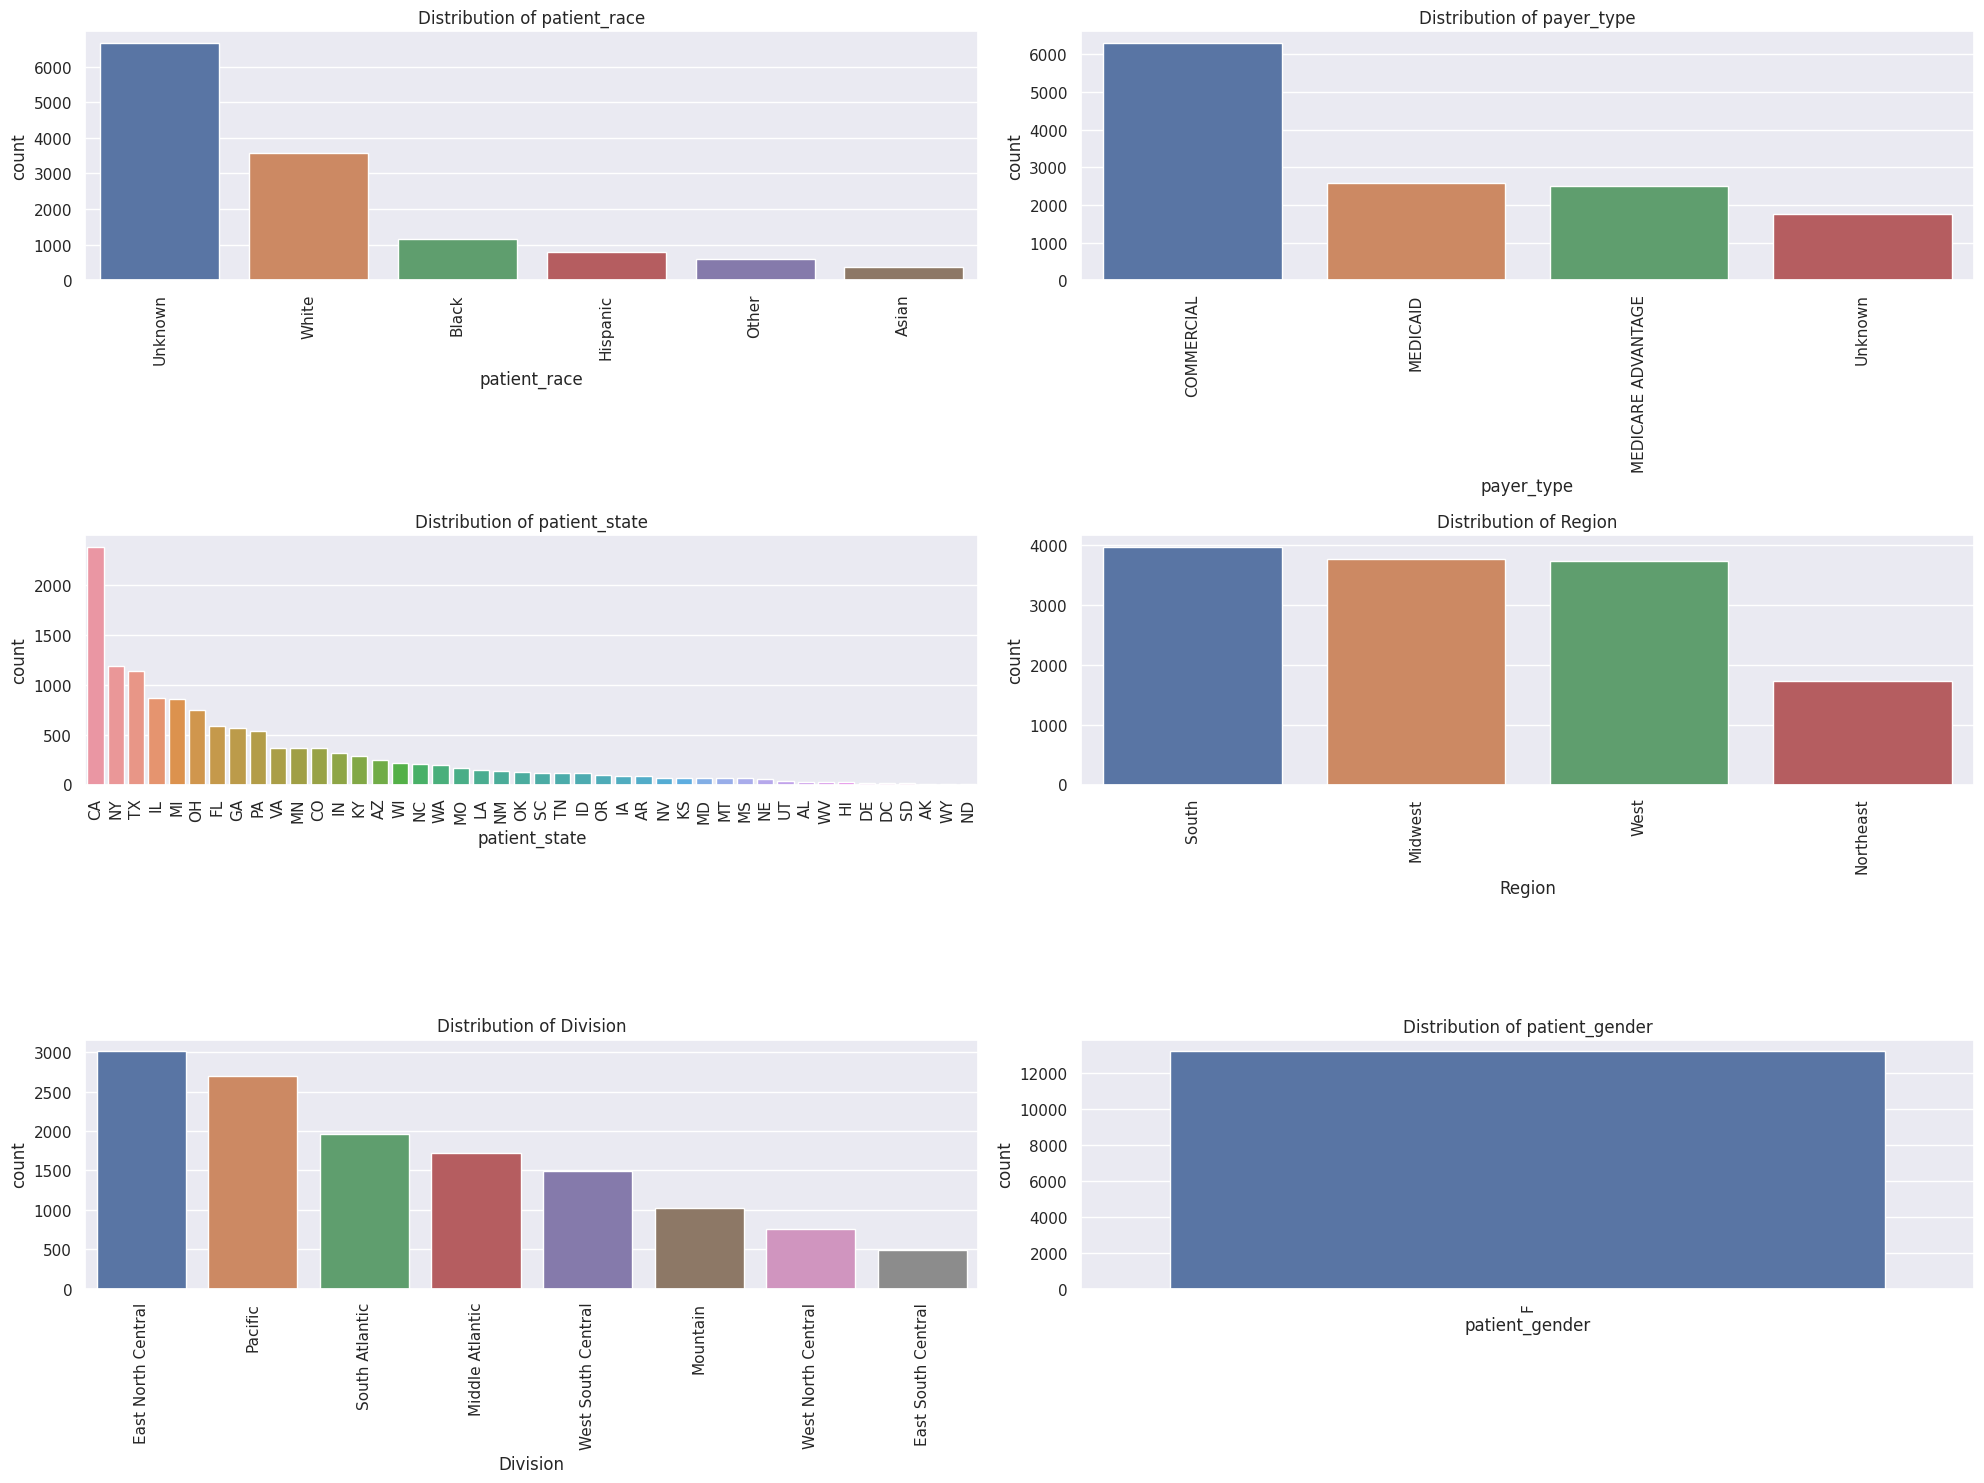

In [38]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plot distributions of key categorical features
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df_train, x=feature, order=df_train[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**The plots above show the distribution of key categorical features**

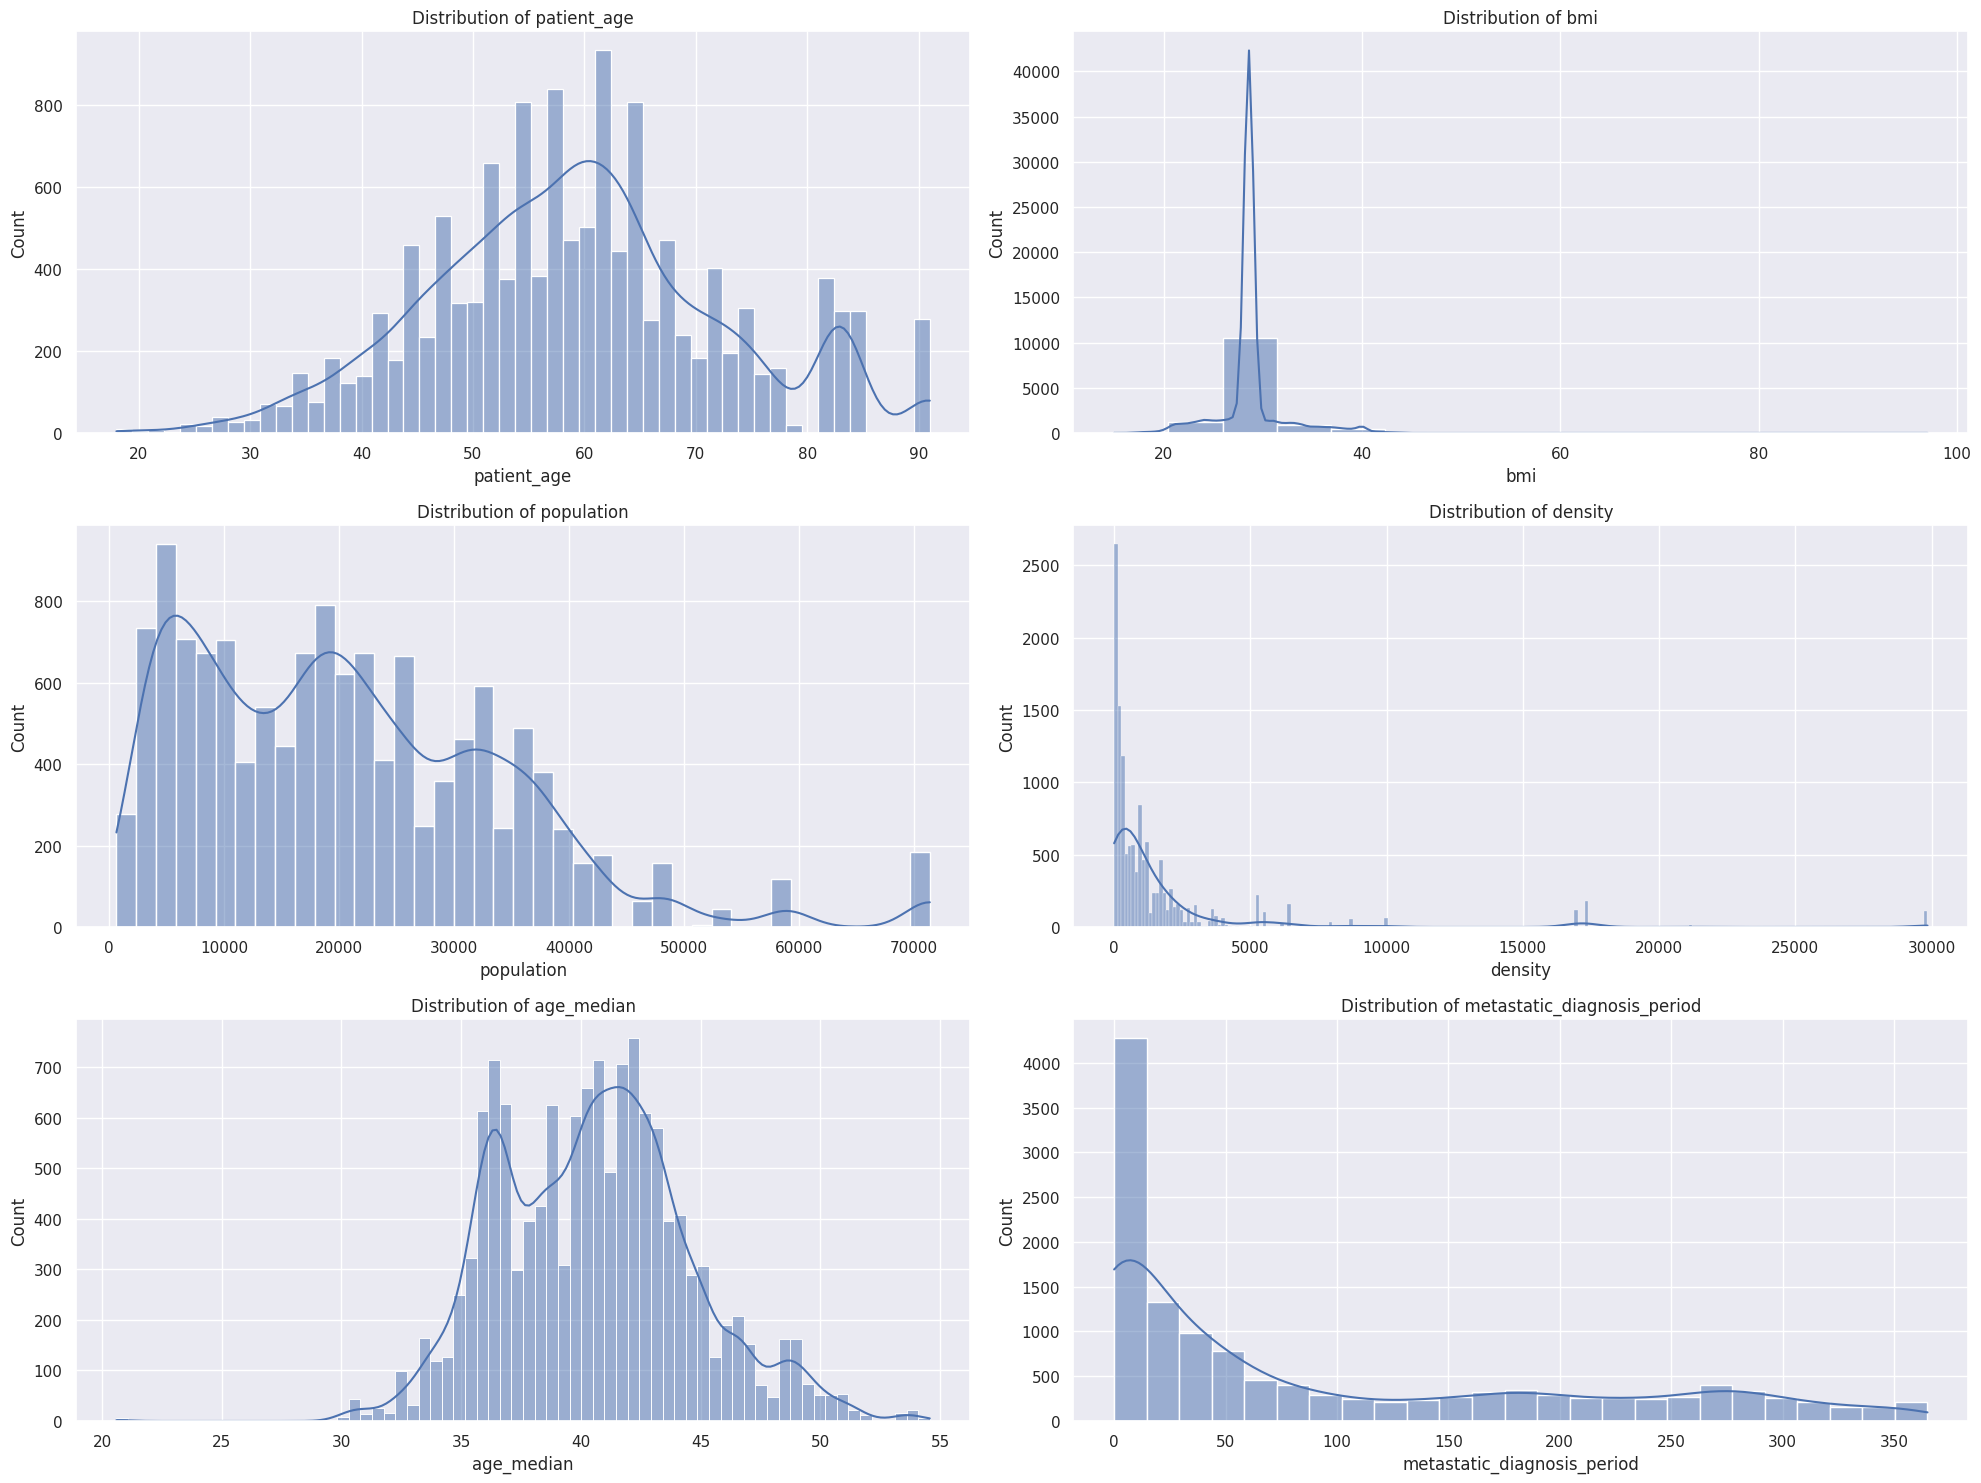

In [39]:
# Visualize the distribution of key numerical features
plt.figure(figsize=(20, 15))

# List of numerical features to visualize
numerical_features = ['patient_age', 'bmi', 'population', 'density', 'age_median', 'metastatic_diagnosis_period']

# Plot distributions of numerical features
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

**Patient Age:**
* Most patients are between 50 and 70 years old.
* The distribution of BMI is roughly normal, centered around 30.

**Population:**
* The distribution is right-skewed, with most values concentrated towards the lower end.

**Density:**
* Highly right-skewed, indicating many patients live in areas with lower population density.

**Age Median:**
* The median age of the population in different regions is clustered around 40.

**Metastatic Diagnosis Period:**
* Right-skewed, with many patients diagnosed within 0 to 100 days.

In [40]:
#Next, let's generate a correlation matrix to examine
#the relationships between numerical features and the target variable metastatic_diagnosis_period.

# Ensure all columns are numeric
numeric_df = df_train.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation with the target variable
target_variable = 'metastatic_diagnosis_period'
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)

# Display the correlation with the target variable
print(correlation_with_target)

metastatic_diagnosis_period    1.00
income_household_10_to_15      0.03
Average of May-15              0.03
poverty                        0.03
widowed                        0.03
                               ... 
patient_zip3                  -0.03
education_bachelors           -0.03
family_dual_income            -0.04
labor_force_participation     -0.04
patient_age                   -0.06
Name: metastatic_diagnosis_period, Length: 141, dtype: float64


**Correlation Analysis**

* The correlation matrix indicates the strength and direction of the relationships between numerical features and the target variable metastatic_diagnosis_period. 

**Weak Correlations:**

* Most features have very weak correlations with the target variable.
* The highest correlation is only 0.03 (income_household_10_to_15), indicating a very weak positive relationship.
* The strongest negative correlation is with patient_age at -0.06, also indicating a weak relationship.

# Feature Engineering

Given the weak correlations, it might be necessary to explore other feature engineering methods, including interactions between features and possibly incorporating more complex models that can capture non-linear relationships.

Create additional features or interactions that might improve predictive power

In [41]:
# Example: Creating new features based on existing ones

# Interaction term between patient_age and bmi
df_train['age_bmi_interaction'] = df_train['patient_age'] * df_train['bmi']

# Calculate the average temperature for the given climate columns
climate_columns = [col 
                   for col in df_train.columns 
                   if 'Average of' in col]
df_train['average_temperature'] = df_train[climate_columns].mean(axis=1)

# Verify the new features
df_train[['patient_age', 'bmi', 'age_bmi_interaction', 'average_temperature']].head()

,patient_age,bmi,age_bmi_interaction,average_temperature
0,39,28.58,"1,114.62",59.08
1,55,35.36,"1,944.80",56.40
2,59,28.58,"1,686.22",70.01
3,59,28.58,"1,686.22",66.69
4,71,28.58,"2,029.18",61.85


Feature Engineering Two new features have been created above:

**Age-BMI Interaction:**
Interaction term between patient_age and bmi.

**Average Temperature:**
Average of the given climate columns

# Model Training and Validation

Train multiple models and evaluate their performance.
Let's start with splitting the data and preparing it for model training.

In [42]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
features = df_train.drop(columns=['metastatic_diagnosis_period', 'patient_id'])
target = df_train['metastatic_diagnosis_period']

# Perform train-test split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Verify the shape of the splits
(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

((10538, 150), (2635, 150), (10538,), (2635,))

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Display RMSE
rmse

ValueError: could not convert string to float: 'White'

**Error Analysis** 
The error occurred because the Linear Regression model cannot handle categorical data directly. We need to convert categorical variables into numerical format using encoding techniques such as one-hot encoding.

**Next Steps: Encode Categorical Variables:**
Convert categorical features into numerical format.

**Train the Linear Regression Model Again:**
Train the model on the encoded data. Let's proceed with encoding the categorical variables and retry training the Linear Regression model. ​

In [44]:
# One-hot encode the categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)

# Align the columns of validation set to match the training set
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Train a Linear Regression model on the encoded data
linear_model = LinearRegression()
linear_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val_encoded)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Display RMSE
rmse

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Error Analysis**

The error indicates that there are still missing values (NaN) in the data, which Linear Regression cannot handle directly.

**Next Steps:**

**Handle Remaining Missing Values:**

Impute or remove the missing values in the encoded dataset.
Train the Linear Regression Model Again:
Train the model on the cleaned, encoded data.

Let's impute the remaining missing values and retry training the Linear Regression model.

In [45]:
from sklearn.impute import SimpleImputer

# Impute remaining missing values with the median for numerical features
imputer = SimpleImputer(strategy='median')
X_train_encoded_imputed = imputer.fit_transform(X_train_encoded)
X_val_encoded_imputed = imputer.transform(X_val_encoded)

# Train the Linear Regression model on the imputed, encoded data
linear_model = LinearRegression()
linear_model.fit(X_train_encoded_imputed, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val_encoded_imputed)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Display RMSE
rmse


82.98676069263816

Let's proceed with training and evaluating a Decision Tree model.

In [46]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_encoded_imputed, y_train)

# Predict on the validation set
y_pred_tree = tree_model.predict(X_val_encoded_imputed)

# Calculate RMSE
rmse_tree = np.sqrt(mean_squared_error(y_val, y_pred_tree))

# Display RMSE
rmse_tree

117.50255114514195

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train_encoded_imputed, y_train)

# Predict on the validation set
y_pred_forest = forest_model.predict(X_val_encoded_imputed)

# Calculate RMSE
rmse_forest = np.sqrt(mean_squared_error(y_val, y_pred_forest))

# Display RMSE
rmse_forest

86.77953379741813

**Linear Regression Model Evaluation**

* The RMSE of the Linear Regression model on the validation set is approximately 82.99.
* The RMSE of the Decision Tree model on the validation set is approximately 117.50, which is higher than the Linear Regression model.
* The RMSE of the Randon Forest model on the validation set is approximately 86.78, which is higher than the Linear Regression model.

# Prediction and Submission

In [48]:
# Prepare the submission file using the Linear Regression model

# Load the test dataset and preprocess similarly
df_test_cleaned = pd.get_dummies(df_test, drop_first=True)
df_test_cleaned = df_test_cleaned.reindex(columns=X_train_encoded.columns, fill_value=0)
df_test_cleaned_imputed = imputer.transform(df_test_cleaned)

# Predict on the test dataset using the trained Linear Regression model
test_predictions = linear_model.predict(df_test_cleaned_imputed)

# Prepare the submission DataFrame
df_submission = pd.DataFrame({
    'patient_id': df_test['patient_id'],
    'metastatic_diagnosis_period': test_predictions
})

# Ensure the metastatic_diagnosis_period is in integer format
df_submission['metastatic_diagnosis_period'] = df_submission['metastatic_diagnosis_period'].round().astype(int)

# Save the submission DataFrame to a CSV file
df_submission.to_csv('/kaggle/working/submission.csv',mode ='a', index=False)

print("file created")

# Display the first few rows of the submission file
df_submission.head()

file created


,patient_id,metastatic_diagnosis_period
0,730681,1409
1,334212,1136
2,571362,1278
3,907331,1189
4,208382,904
